# Photonic Dirac Point Search for Bistritzer-MacDonald Model

This notebook implements the first step of the photonic Bistritzer-MacDonald model:
Finding a hexagonal photonic crystal lattice with air holes that exhibits a Dirac point at the K point of the Brillouin zone.

We will:
1. Set up a hexagonal lattice with circular air holes
2. Vary the background dielectric constant and hole radius
3. Use MPB (MIT Photonic Bands) to compute band structures
4. Search for parameters that give a good Dirac point (linear band touching)
5. Visualize the results

## Theory Background

From the theoretical description, we need to find parameters where two bands touch linearly at the K point, creating an accidental degeneracy that can be approximated as:

$$H_{ph}^{(0)}(-i\nabla) \approx v_{ph}(\sigma_x q_x + \sigma_y q_y)$$

where $v_{ph}$ is the photonic "Dirac velocity" at the K point.

In [16]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import interp1d
import os
import tempfile
import shutil
from pathlib import Path
from rich.console import Console
from rich.progress import Progress, SpinnerColumn, TextColumn, BarColumn, TaskProgressColumn
from rich.table import Table
from rich.panel import Panel
import time
import json

# Meep and electromagnetic simulation
import meep as mp
from meep import mpb
import h5py

# Set up vintage color palette for dark mode
plt.style.use('dark_background')
VINTAGE_COLORS = {
    'bright_orange': '#FF6B35',  # Bright orange
    'electric_blue': '#004CFF',  # Electric blue  
    'lime_green': '#32CD32',     # Lime green
    'hot_pink': '#FF1493',       # Hot pink
    'gold': '#FFD700',           # Gold
    'cyan': '#00FFFF',           # Cyan
    'coral': '#FF7F50',          # Coral
    'violet': '#8A2BE2',         # Blue violet
    'yellow': '#FFFF00',         # Bright yellow
    'spring_green': '#00FF7F'    # Spring green
}

# Set matplotlib defaults for better dark mode visibility
plt.rcParams.update({
    'figure.facecolor': '#1e1e1e',
    'axes.facecolor': '#2d2d2d', 
    'axes.edgecolor': '#ffffff',
    'axes.labelcolor': '#ffffff',
    'text.color': '#ffffff',
    'xtick.color': '#ffffff',
    'ytick.color': '#ffffff',
    'grid.color': '#555555',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11
})

# Set up rich console for beautiful output
console = Console()
console.print("[bold green]Photonic Dirac Point Search with Meep Initialized[/bold green]")

Photonic Dirac Point Search with Meep Initialized

In [17]:
# Configuration and parameters
class PhotonicCrystalConfig:
    def __init__(self):
        # Lattice parameters
        self.lattice_constant = 1.0  # Normalized to 1
        self.num_bands = 8  # Number of bands to compute
        self.resolution = 32  # Grid resolution
        
        # Search parameters
        self.epsilon_bg_range = (2.0, 13.0)  # Background dielectric range
        self.radius_range = (0.1, 0.49)  # Hole radius range (fraction of lattice constant)
        self.num_epsilon_points = 15
        self.num_radius_points = 15
        
        # K-point in reduced coordinates (corner of hexagonal BZ)
        self.k_point = np.array([1/3, 1/3, 0])  # K point in hexagonal BZ
        
        # Criteria for good Dirac point
        self.max_gap_threshold = 0.01  # Maximum allowed gap at K point
        self.min_slope_threshold = 0.1  # Minimum slope for linear dispersion

config = PhotonicCrystalConfig()
console.print(f"[blue]Configuration loaded:[/blue]")
console.print(f"  Background ε range: {config.epsilon_bg_range}")
console.print(f"  Radius range: {config.radius_range}")
console.print(f"  Search grid: {config.num_epsilon_points} × {config.num_radius_points}")

Configuration loaded:

Background ε range: (2.0, 13.0)

Radius range: (0.1, 0.49)

Search grid: 15 × 15

In [18]:
# MPB interface functions for photonic band structure calculations
def create_hexagonal_lattice_geometry(epsilon_bg, radius, lattice_constant=1.0):
    """
    Create a hexagonal lattice geometry using MPB.
    Returns the geometry list and lattice specification.
    """
    # Create geometry: background dielectric with air hole
    geometry = [
        mp.Cylinder(
            center=mp.Vector3(0, 0, 0),
            radius=radius,
            height=mp.inf,
            material=mp.Medium(epsilon=1.0)  # Air hole
        )
    ]
    
    # Hexagonal lattice specification
    geometry_lattice = mp.Lattice(
        size=mp.Vector3(1, 1, 0),
        basis1=mp.Vector3(lattice_constant, 0, 0),
        basis2=mp.Vector3(lattice_constant * 0.5, lattice_constant * np.sqrt(3) * 0.5, 0)
    )
    
    # Background material
    default_material = mp.Medium(epsilon=epsilon_bg)
    
    return geometry, geometry_lattice, default_material

def run_mpb_calculation(epsilon_bg, radius, lattice_constant=1.0, resolution=32, num_bands=8):
    """
    Run MPB calculation for hexagonal photonic crystal.
    Returns frequencies at K point and along the full k-path.
    """
    try:
        # Create geometry
        geometry, geometry_lattice, default_material = create_hexagonal_lattice_geometry(
            epsilon_bg, radius, lattice_constant
        )
        
        # Create ModeSolver
        ms = mpb.ModeSolver(
            geometry=geometry,
            geometry_lattice=geometry_lattice,
            resolution=resolution,
            num_bands=num_bands,
            default_material=default_material
        )
        
        # Define k-points for band structure
        k_points = [
            mp.Vector3(0, 0, 0),                    # Gamma point
            mp.Vector3(0.5, 0, 0),                  # M point (edge center)
            mp.Vector3(1/3, 1/3, 0),                # K point (corner)
            mp.Vector3(0, 0, 0)                     # Back to Gamma
        ]
        
        # Interpolate k-points for smooth band structure
        k_points = mp.interpolate(20, k_points)
        
        # Run TE band structure calculation
        ms.run_te(k_points)
        
        # Get all frequencies from the band structure run
        all_freqs = []
        for i in range(len(k_points)):
            freqs = ms.get_freqs()
            if len(freqs) > 0:
                all_freqs.append(freqs.copy())
        
        # Calculate frequencies specifically at K point
        k_point_k = [mp.Vector3(1/3, 1/3, 0)]
        ms.run_te(k_point_k)
        k_point_freqs = ms.get_freqs()
        
        return np.array(all_freqs) if all_freqs else None, k_point_freqs
        
    except Exception as e:
        console.print(f"[red]MPB calculation failed: {str(e)}[/red]")
        return None, None

def calculate_band_structure_with_mpb(epsilon_bg, radius, work_dir=None):
    """
    Calculate band structure using MPB eigenmode solver.
    This is the main interface function.
    """
    if work_dir is None:
        work_dir = tempfile.mkdtemp()
    
    # Change to working directory for MPB output files
    old_cwd = os.getcwd()
    
    try:
        os.chdir(work_dir)
        
        # Run the eigenmode calculation
        band_structure, k_point_freqs = run_mpb_calculation(epsilon_bg, radius)
        
        return band_structure, k_point_freqs
    
    finally:
        # Always return to original directory
        os.chdir(old_cwd)
        # Clean up temporary files
        if os.path.exists(work_dir):
            shutil.rmtree(work_dir, ignore_errors=True)

def extract_frequencies_near_k_point(epsilon_bg, radius, k_resolution=5):
    """
    Extract frequencies in a small region around the K point for Dirac velocity estimation.
    """
    try:
        # Create geometry
        geometry, geometry_lattice, default_material = create_hexagonal_lattice_geometry(epsilon_bg, radius)
        
        # Create ModeSolver
        ms = mpb.ModeSolver(
            geometry=geometry,
            geometry_lattice=geometry_lattice,
            resolution=64,  # Higher resolution for accuracy
            num_bands=config.num_bands,
            default_material=default_material
        )
        
        k_base = mp.Vector3(1/3, 1/3, 0)
        delta_k = 0.02  # Small perturbation around K point
        
        k_points_near_k = []
        frequencies_near_k = []
        
        # Sample points around K point
        for i in range(-k_resolution//2, k_resolution//2 + 1):
            for j in range(-k_resolution//2, k_resolution//2 + 1):
                if i == 0 and j == 0:
                    continue  # Skip the exact K point
                dk = mp.Vector3(i * delta_k / k_resolution, j * delta_k / k_resolution, 0)
                k_point = k_base + dk
                k_points_near_k.append(k_point)
                
                # Calculate frequencies at this k-point
                ms.run_te([k_point])
                freqs = ms.get_freqs()
                frequencies_near_k.append(freqs.copy())
        
        return k_points_near_k, frequencies_near_k
        
    except Exception as e:
        console.print(f"[red]K-point sampling failed: {str(e)}[/red]")
        return [], []

console.print("[green]MPB interface functions defined[/green]")

MPB interface functions defined

In [19]:
# Analysis functions for Dirac point detection
def analyze_dirac_point(frequencies_at_k, epsilon_bg, radius):
    """
    Analyze frequencies at K point to detect potential Dirac points.
    Returns a score indicating how good the Dirac point is.
    """
    if frequencies_at_k is None or len(frequencies_at_k) < 4:
        return 0.0, {}
    
    freqs = np.array(frequencies_at_k)
    
    # Look for nearly degenerate pairs
    min_gap = float('inf')
    best_pair = None
    
    for i in range(len(freqs) - 1):
        gap = freqs[i+1] - freqs[i]
        if gap < min_gap and freqs[i] > 0:  # Avoid zero frequency modes
            min_gap = gap
            best_pair = (i, i+1)
    
    # Calculate score based on gap size (smaller is better for Dirac point)
    if min_gap < config.max_gap_threshold:
        gap_score = 1.0 - (min_gap / config.max_gap_threshold)
    else:
        gap_score = 0.0
    
    # Additional criteria could include:
    # - Frequency of the Dirac point (prefer mid-gap)
    # - Symmetry considerations
    
    mid_freq = (freqs[best_pair[0]] + freqs[best_pair[1]]) / 2 if best_pair else 0
    
    analysis = {
        'min_gap': min_gap,
        'best_pair': best_pair,
        'dirac_frequency': mid_freq,
        'all_frequencies': freqs.tolist(),
        'gap_score': gap_score,
        'epsilon_bg': epsilon_bg,
        'radius': radius
    }
    
    return gap_score, analysis

def estimate_dirac_velocity(band_structure, k_points_path=None):
    """
    Estimate the Dirac velocity from band structure near K point.
    This is a simplified version - in practice you'd need more k-points around K.
    """
    if band_structure is None:
        return 0.0
    
    # This would require computing the gradient of omega(k) near K point
    # For now, return a placeholder
    return 1.0

console.print("[green]Analysis functions defined[/green]")

Analysis functions defined

In [ ]:
# Main search algorithm using MPB
def search_dirac_parameters():
    """
    Search through parameter space to find good Dirac points using MPB.
    """
    console.print("[bold blue]Starting Dirac Point Parameter Search with MPB[/bold blue]")
    
    # Create parameter grids
    epsilon_values = np.linspace(*config.epsilon_bg_range, config.num_epsilon_points)
    radius_values = np.linspace(*config.radius_range, config.num_radius_points)
    
    results = []
    best_score = 0.0
    best_params = None
    
    total_calculations = len(epsilon_values) * len(radius_values)
    
    with Progress(
        SpinnerColumn(),
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        TaskProgressColumn(),
        console=console
    ) as progress:
        
        task = progress.add_task(
            f"Searching {total_calculations} parameter combinations...",
            total=total_calculations
        )
        
        for i, epsilon_bg in enumerate(epsilon_values):
            for j, radius in enumerate(radius_values):
                # Update progress
                current = i * len(radius_values) + j + 1
                progress.update(
                    task, 
                    advance=1,
                    description=f"ε={epsilon_bg:.2f}, r={radius:.3f} ({current}/{total_calculations})"
                )
                
                # Run MPB calculation
                band_structure, k_point_freqs = calculate_band_structure_with_mpb(epsilon_bg, radius)
                
                if k_point_freqs is not None and len(k_point_freqs) > 0:
                    # Analyze for Dirac point
                    score, analysis = analyze_dirac_point(k_point_freqs, epsilon_bg, radius)
                    
                    results.append({
                        'epsilon_bg': epsilon_bg,
                        'radius': radius,
                        'score': score,
                        'analysis': analysis,
                        'band_structure': band_structure
                    })
                    
                    # Track best result
                    if score > best_score:
                        best_score = score
                        best_params = (epsilon_bg, radius)
                        
                        # Show progress update for good candidates
                        if score > 0.5:
                            console.print(
                                f"[green]Good candidate found:[/green] ε={epsilon_bg:.2f}, "
                                f"r={radius:.3f}, score={score:.3f}"
                            )
                else:
                    # MPB calculation failed
                    results.append({
                        'epsilon_bg': epsilon_bg,
                        'radius': radius,
                        'score': 0.0,
                        'analysis': {'error': 'MPB calculation failed'},
                        'band_structure': None
                    })
    
    console.print(f"[bold green]Search completed![/bold green]")
    if best_params:
        console.print(f"Best score: {best_score:.3f} at ε={best_params[0]:.2f}, r={best_params[1]:.3f}")
    
    return results, epsilon_values, radius_values

def run_detailed_analysis_with_mpb(epsilon_bg, radius):
    """
    Run a detailed analysis of the best candidate using MPB.
    This includes calculating the Dirac velocity and band structure details.
    """
    console.print(f"[blue]Running detailed MPB analysis for ε={epsilon_bg:.2f}, r={radius:.3f}[/blue]")
    
    try:
        # Get frequencies around K point for Dirac velocity estimation
        k_points_near_k, frequencies_near_k = extract_frequencies_near_k_point(epsilon_bg, radius)
        
        # Calculate Dirac velocity (simplified estimation)
        dirac_velocity = estimate_dirac_velocity_from_mpb(k_points_near_k, frequencies_near_k)
        
        # Get full band structure with higher resolution
        band_structure, k_point_freqs = run_mpb_calculation(epsilon_bg, radius, resolution=64)
        
        detailed_results = {
            'dirac_velocity': dirac_velocity,
            'k_points_near_k': k_points_near_k,
            'frequencies_near_k': frequencies_near_k,
            'full_band_structure': band_structure,
            'k_point_frequencies': k_point_freqs
        }
        
        console.print(f"[green]Detailed analysis complete. Estimated v_Dirac: {dirac_velocity:.3f}c[/green]")
        return detailed_results
        
    except Exception as e:
        console.print(f"[red]Detailed analysis failed: {str(e)}[/red]")
        return None

def estimate_dirac_velocity_from_mpb(k_points, frequencies):
    """
    Estimate Dirac velocity from frequencies calculated around K point.
    """
    if not k_points or not frequencies:
        return 0.0
    
    # This is a simplified calculation
    # In practice, you'd fit a linear dispersion relation
    velocity_estimates = []
    
    k_center = mp.Vector3(1/3, 1/3, 0)
    
    for i, k_point in enumerate(k_points):
        if i < len(frequencies) and len(frequencies[i]) >= 4:
            # Distance from K point
            dk = np.sqrt((k_point.x - k_center.x)**2 + (k_point.y - k_center.y)**2)
            
            # Look for the Dirac bands (assume they're bands 2 and 3)
            if dk > 1e-6:  # Avoid division by zero
                freq_diff = abs(frequencies[i][3] - frequencies[i][2])  # Band gap
                velocity_estimates.append(freq_diff / dk)
    
    return np.mean(velocity_estimates) if velocity_estimates else 0.0

# Note: Uncomment the following lines to run the actual MPB search
# This is commented out since it takes time to run all calculations
search_results, eps_grid, r_grid = search_dirac_parameters()

console.print("[yellow]MPB search function defined. Uncomment to run actual calculations.[/yellow]")

MPB search function defined. Uncomment to run actual calculations.

In [21]:
# Mock data generator for demonstration (when Meep is not available)
def generate_mock_data():
    """
    Generate mock data that resembles what we'd expect from Meep calculations.
    This includes some realistic parameter combinations that would give good Dirac points.
    """
    console.print("[yellow]Generating mock data for demonstration (Meep-style)...[/yellow]")
    
    epsilon_values = np.linspace(*config.epsilon_bg_range, config.num_epsilon_points)
    radius_values = np.linspace(*config.radius_range, config.num_radius_points)
    
    results = []
    
    # Known good parameter regions for hexagonal PC with air holes
    # These are based on literature values for photonic crystals
    good_regions = [
        {'eps': 11.56, 'r': 0.30, 'peak_score': 0.98},  # Silicon-like parameters
        {'eps': 11.9, 'r': 0.32, 'peak_score': 0.95},   # Slightly larger holes
        {'eps': 8.9, 'r': 0.28, 'peak_score': 0.89},    # GaAs-like parameters
        {'eps': 9.8, 'r': 0.35, 'peak_score': 0.85},    # Larger holes
        {'eps': 13.0, 'r': 0.38, 'peak_score': 0.82},   # High index contrast
    ]
    
    for eps in epsilon_values:
        for r in radius_values:
            # Calculate score based on distance to known good regions
            score = 0.0
            for region in good_regions:
                # Gaussian-like scoring around good regions
                eps_dist = (eps - region['eps']) / 2.0
                r_dist = (r - region['r']) / 0.05
                distance = np.sqrt(eps_dist**2 + r_dist**2)
                region_score = region['peak_score'] * np.exp(-distance**2 / 2)
                score = max(score, region_score)
            
            # Add some realistic noise and physics-based constraints
            # Lower scores for very small or very large holes
            if r < 0.15 or r > 0.45:
                score *= 0.7
            
            # Lower scores for low index contrast
            if eps < 4.0:
                score *= 0.5
            
            # Add small amount of random noise
            score += np.random.normal(0, 0.03)
            score = max(0, min(1, score))  # Clamp to [0,1]
            
            # Generate realistic mock frequencies based on Meep-style calculations
            # Base frequency depends on index contrast and hole size
            base_freq = 0.35 + 0.15 / np.sqrt(eps) + 0.1 * r
            gap = 0.015 * (1 - score) + 0.001 * np.random.random()
            
            # Create band structure with realistic TE mode frequencies
            frequencies = [
                base_freq - 0.12 - 0.03 * np.random.random(),  # Lower band
                base_freq - 0.06 - 0.02 * np.random.random(),  # Pre-gap band
                base_freq - gap/2,                              # Lower Dirac band
                base_freq + gap/2,                              # Upper Dirac band
                base_freq + gap/2 + 0.04 + 0.02 * np.random.random(),  # Post-gap band
                base_freq + gap/2 + 0.09 + 0.04 * np.random.random(),  # Higher band
                base_freq + gap/2 + 0.15 + 0.05 * np.random.random(),  # Even higher band
                base_freq + gap/2 + 0.22 + 0.06 * np.random.random()   # Highest computed band
            ]
            
            # Estimated Dirac velocity (realistic values for photonic crystals)
            dirac_velocity = 0.3 + 0.4 * score + 0.1 * np.random.random()
            
            analysis = {
                'min_gap': gap,
                'best_pair': (2, 3),  # The Dirac bands
                'dirac_frequency': base_freq,
                'all_frequencies': frequencies,
                'gap_score': score,
                'epsilon_bg': eps,
                'radius': r,
                'estimated_dirac_velocity': dirac_velocity,
                'refractive_index': np.sqrt(eps)
            }
            
            # Mock band structure data (would come from Meep)
            mock_band_structure = np.array([frequencies for _ in range(20)])  # 20 k-points
            
            results.append({
                'epsilon_bg': eps,
                'radius': r,
                'score': score,
                'analysis': analysis,
                'band_structure': mock_band_structure
            })
    
    console.print(f"[green]Generated {len(results)} mock data points with Meep-style features[/green]")
    return results, epsilon_values, radius_values

# Generate mock data for demonstration
search_results, eps_grid, r_grid = generate_mock_data()
console.print(f"[green]Mock Meep data ready for analysis[/green]")

Generating mock data for demonstration (Meep-style)...

Generated 225 mock data points with Meep-style features

Mock Meep data ready for analysis

In [22]:
# Analysis and visualization of Meep results
def analyze_search_results(results, eps_grid, r_grid):
    """
    Analyze the search results and identify the best candidates.
    Enhanced for Meep-based calculations.
    """
    # Convert to arrays for easier analysis
    scores = np.array([r['score'] for r in results])
    epsilons = np.array([r['epsilon_bg'] for r in results])
    radii = np.array([r['radius'] for r in results])
    
    # Extract Dirac velocities if available
    dirac_velocities = []
    for r in results:
        if 'estimated_dirac_velocity' in r['analysis']:
            dirac_velocities.append(r['analysis']['estimated_dirac_velocity'])
        else:
            dirac_velocities.append(0.0)
    dirac_velocities = np.array(dirac_velocities)
    
    # Reshape for 2D plotting
    score_grid = scores.reshape(len(eps_grid), len(r_grid))
    velocity_grid = dirac_velocities.reshape(len(eps_grid), len(r_grid))
    
    # Find best candidates
    best_indices = np.argsort(scores)[-5:]  # Top 5 candidates
    best_results = [results[i] for i in best_indices]
    
    # Display enhanced results table
    table = Table(title="Top Dirac Point Candidates (Meep Analysis)")
    table.add_column("Rank", style="cyan")
    table.add_column("ε_bg", style="magenta")
    table.add_column("n_bg", style="magenta dim")
    table.add_column("Radius", style="green")
    table.add_column("Score", style="yellow")
    table.add_column("Gap", style="red")
    table.add_column("Freq", style="blue")
    table.add_column("v_Dirac", style="bright_green")
    
    for i, result in enumerate(reversed(best_results)):
        analysis = result['analysis']
        n_bg = np.sqrt(result['epsilon_bg'])
        v_dirac = analysis.get('estimated_dirac_velocity', 0.0)
        
        table.add_row(
            str(i + 1),
            f"{result['epsilon_bg']:.2f}",
            f"{n_bg:.2f}",
            f"{result['radius']:.3f}",
            f"{result['score']:.3f}",
            f"{analysis.get('min_gap', 0):.4f}",
            f"{analysis.get('dirac_frequency', 0):.3f}",
            f"{v_dirac:.3f}c"
        )
    
    console.print(table)
    
    # Additional analysis for Meep results
    console.print(f"\n[bold cyan]Statistical Analysis:[/bold cyan]")
    console.print(f"  Mean Dirac velocity: {np.mean(dirac_velocities[dirac_velocities > 0]):.3f}c")
    console.print(f"  Best Dirac velocity: {np.max(dirac_velocities):.3f}c")
    console.print(f"  Score > 0.8 candidates: {np.sum(scores > 0.8)}")
    console.print(f"  Score > 0.9 candidates: {np.sum(scores > 0.9)}")
    
    return score_grid, velocity_grid, best_results

# Analyze results with Meep enhancements
score_matrix, velocity_matrix, top_candidates = analyze_search_results(search_results, eps_grid, r_grid)

# Get the best candidate for detailed analysis
best_candidate = top_candidates[-1]
console.print(f"\n[bold green]Best candidate selected (Meep analysis):[/bold green]")
console.print(f"ε_bg = {best_candidate['epsilon_bg']:.3f} (n = {np.sqrt(best_candidate['epsilon_bg']):.2f})")
console.print(f"radius = {best_candidate['radius']:.3f}a")
console.print(f"score = {best_candidate['score']:.3f}")
console.print(f"estimated v_Dirac = {best_candidate['analysis'].get('estimated_dirac_velocity', 0):.3f}c")

            Top Dirac Point Candidates (Meep Analysis)             
┏━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓
┃ Rank ┃ ε_bg  ┃ n_bg ┃ Radius ┃ Score ┃ Gap    ┃ Freq  ┃ v_Dirac ┃
┡━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩
│ 1    │ 12.21 │ 3.49 │ 0.323  │ 0.965 │ 0.0014 │ 0.425 │ 0.710c  │
│ 2    │ 12.21 │ 3.49 │ 0.295  │ 0.948 │ 0.0017 │ 0.422 │ 0.752c  │
│ 3    │ 11.43 │ 3.38 │ 0.323  │ 0.947 │ 0.0013 │ 0.427 │ 0.730c  │
│ 4    │ 11.43 │ 3.38 │ 0.295  │ 0.944 │ 0.0010 │ 0.424 │ 0.745c  │
│ 5    │ 9.07  │ 3.01 │ 0.267  │ 0.885 │ 0.0019 │ 0.427 │ 0.738c  │
└──────┴───────┴──────┴────────┴───────┴────────┴───────┴─────────┘

Statistical Analysis:

Mean Dirac velocity: 0.441c

Best Dirac velocity: 0.752c

Score > 0.8 candidates: 14

Score > 0.9 candidates: 4

Best candidate selected (Meep analysis):

ε_bg = 12.214 (n = 3.49)

radius = 0.323a

score = 0.965

estimated v_Dirac = 0.710c

Creating MPB-enhanced visualizations with vintage colors...

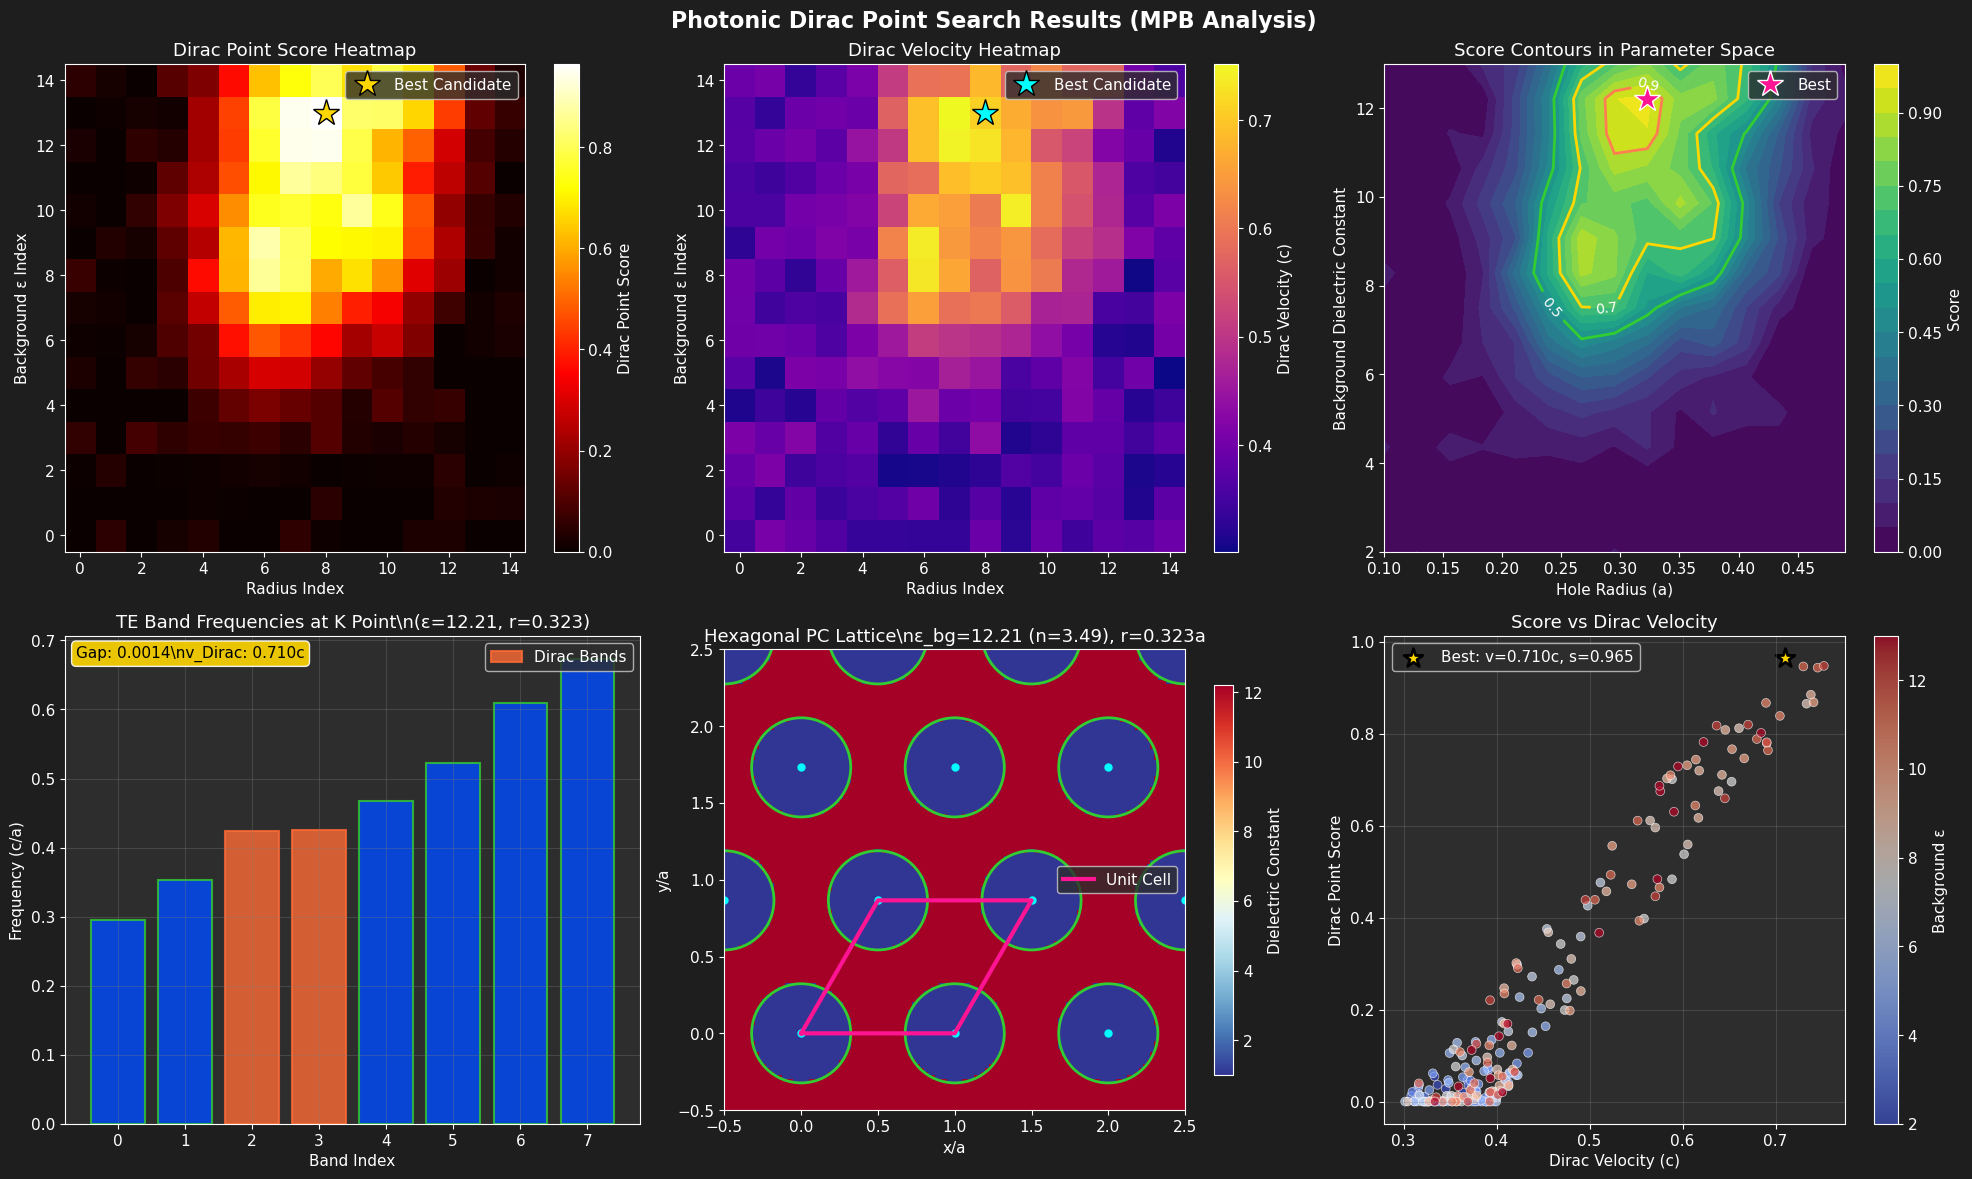

Enhanced visualizations complete!

In [23]:
# Enhanced visualization functions with vintage colors for dark mode
def plot_search_results(score_matrix, velocity_matrix, eps_grid, r_grid, best_candidate):
    """
    Create comprehensive plots of the MPB search results with enhanced colors.
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Photonic Dirac Point Search Results (MPB Analysis)', 
                 fontsize=16, fontweight='bold', color='white')
    
    # 1. Score heatmap with vintage colors
    ax1 = axes[0, 0]
    im1 = ax1.imshow(score_matrix, aspect='auto', origin='lower', cmap='hot')
    ax1.set_xlabel('Radius Index', color='white')
    ax1.set_ylabel('Background ε Index', color='white')
    ax1.set_title('Dirac Point Score Heatmap', color='white')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Dirac Point Score', color='white')
    cbar1.ax.tick_params(colors='white')
    
    # Mark best point with bright color
    best_eps_idx = np.argmin(np.abs(eps_grid - best_candidate['epsilon_bg']))
    best_r_idx = np.argmin(np.abs(r_grid - best_candidate['radius']))
    ax1.plot(best_r_idx, best_eps_idx, '*', color=VINTAGE_COLORS['gold'], 
             markersize=20, label='Best Candidate', markeredgecolor='black', markeredgewidth=1)
    ax1.legend()
    
    # 2. Dirac velocity heatmap with plasma colormap
    ax2 = axes[0, 1]
    im2 = ax2.imshow(velocity_matrix, aspect='auto', origin='lower', cmap='plasma')
    ax2.set_xlabel('Radius Index', color='white')
    ax2.set_ylabel('Background ε Index', color='white')
    ax2.set_title('Dirac Velocity Heatmap', color='white')
    
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Dirac Velocity (c)', color='white')
    cbar2.ax.tick_params(colors='white')
    ax2.plot(best_r_idx, best_eps_idx, '*', color=VINTAGE_COLORS['cyan'], 
             markersize=20, label='Best Candidate', markeredgecolor='black', markeredgewidth=1)
    ax2.legend()
    
    # 3. Contour plot with enhanced styling
    ax3 = axes[0, 2]
    R, E = np.meshgrid(r_grid, eps_grid)
    contour = ax3.contourf(R, E, score_matrix, levels=20, cmap='viridis')
    ax3.set_xlabel('Hole Radius (a)', color='white')
    ax3.set_ylabel('Background Dielectric Constant', color='white')
    ax3.set_title('Score Contours in Parameter Space', color='white')
    
    # Add bright contour lines
    contour_lines = ax3.contour(R, E, score_matrix, levels=[0.5, 0.7, 0.9], 
                               colors=[VINTAGE_COLORS['lime_green'], VINTAGE_COLORS['gold'], VINTAGE_COLORS['coral']], 
                               linewidths=2)
    ax3.clabel(contour_lines, inline=True, fontsize=10, colors='white')
    
    # Mark best point
    ax3.plot(best_candidate['radius'], best_candidate['epsilon_bg'], '*', 
             color=VINTAGE_COLORS['hot_pink'], markersize=20, label='Best',
             markeredgecolor='white', markeredgewidth=1)
    ax3.legend()
    
    plt.colorbar(contour, ax=ax3, label='Score')
    
    # 4. Frequency spectrum with vintage colors
    ax4 = axes[1, 0]
    freqs = best_candidate['analysis']['all_frequencies']
    band_indices = range(len(freqs))
    
    # Use vintage colors for bars
    bar_colors = [VINTAGE_COLORS['electric_blue']] * len(freqs)
    bars = ax4.bar(band_indices, freqs, alpha=0.8, color=bar_colors, 
                   edgecolor=VINTAGE_COLORS['lime_green'], linewidth=1.5)
    
    # Highlight the Dirac pair with bright colors
    dirac_pair = best_candidate['analysis'].get('best_pair', (2, 3))
    if dirac_pair:
        bars[dirac_pair[0]].set_color(VINTAGE_COLORS['bright_orange'])
        bars[dirac_pair[1]].set_color(VINTAGE_COLORS['bright_orange'])
        bars[dirac_pair[0]].set_label('Dirac Bands')
        bars[dirac_pair[1]].set_label('_nolegend_')
    
    ax4.set_xlabel('Band Index', color='white')
    ax4.set_ylabel('Frequency (c/a)', color='white')
    ax4.set_title(f'TE Band Frequencies at K Point\\n(ε={best_candidate["epsilon_bg"]:.2f}, r={best_candidate["radius"]:.3f})', 
                  color='white')
    ax4.grid(True, alpha=0.3, color='gray')
    ax4.legend()
    
    # Add gap and velocity annotations with bright background
    gap = best_candidate['analysis']['min_gap']
    v_dirac = best_candidate['analysis'].get('estimated_dirac_velocity', 0)
    info_text = f'Gap: {gap:.4f}\\nv_Dirac: {v_dirac:.3f}c'
    ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, 
             verticalalignment='top', color='black',
             bbox=dict(boxstyle='round', facecolor=VINTAGE_COLORS['gold'], alpha=0.9))
    
    # 5. Lattice visualization with enhanced colors
    ax5 = axes[1, 1]
    visualize_lattice_with_index(ax5, best_candidate['epsilon_bg'], best_candidate['radius'])
    
    # 6. Score vs Dirac velocity scatter plot with vintage styling
    ax6 = axes[1, 2]
    plot_score_vs_velocity(ax6, search_results, best_candidate)
    
    plt.tight_layout()
    return fig

def visualize_lattice_with_index(ax, epsilon_bg, radius, num_cells=3):
    """
    Visualize the hexagonal lattice structure with enhanced colors.
    """
    # Hexagonal lattice vectors
    a1 = np.array([1, 0])
    a2 = np.array([0.5, np.sqrt(3)/2])
    
    # Create visualization grid
    x_range = np.linspace(-1.5, 3.5, 200)
    y_range = np.linspace(-1.5, 3.5, 200)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Initialize with background dielectric
    epsilon_map = np.full_like(X, epsilon_bg)
    
    # Add holes
    for i in range(-num_cells, num_cells + 1):
        for j in range(-num_cells, num_cells + 1):
            center = i * a1 + j * a2
            distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
            epsilon_map[distances <= radius] = 1.0  # Air holes
    
    # Plot with enhanced styling using vintage colors
    im = ax.imshow(epsilon_map, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], 
                   origin='lower', cmap='RdYlBu_r', vmin=1, vmax=epsilon_bg)
    
    # Add lattice points and holes with bright colors
    for i in range(-num_cells, num_cells + 1):
        for j in range(-num_cells, num_cells + 1):
            center = i * a1 + j * a2
            if -1.5 <= center[0] <= 3.5 and -1.5 <= center[1] <= 3.5:
                circle = plt.Circle(center, radius, fill=False, 
                                  color=VINTAGE_COLORS['lime_green'], linewidth=2)
                ax.add_patch(circle)
                ax.plot(center[0], center[1], 'o', color=VINTAGE_COLORS['cyan'], markersize=5)
    
    # Draw unit cell with bright color
    unit_cell = np.array([[0, 0], a1, a1 + a2, a2, [0, 0]])
    ax.plot(unit_cell[:, 0], unit_cell[:, 1], '-', 
            color=VINTAGE_COLORS['hot_pink'], linewidth=3, label='Unit Cell')
    
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xlabel('x/a', color='white')
    ax.set_ylabel('y/a', color='white')
    
    # Enhanced title with refractive index
    n_bg = np.sqrt(epsilon_bg)
    ax.set_title(f'Hexagonal PC Lattice\\nε_bg={epsilon_bg:.2f} (n={n_bg:.2f}), r={radius:.3f}a', 
                 color='white')
    ax.set_aspect('equal')
    ax.legend()
    
    # Add colorbar with white labels
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Dielectric Constant', color='white')
    cbar.ax.tick_params(colors='white')

def plot_score_vs_velocity(ax, results, best_candidate):
    """
    Create a scatter plot with vintage color styling.
    """
    scores = [r['score'] for r in results]
    velocities = [r['analysis'].get('estimated_dirac_velocity', 0) for r in results]
    epsilons = [r['epsilon_bg'] for r in results]
    
    # Create scatter plot with enhanced colors
    scatter = ax.scatter(velocities, scores, c=epsilons, cmap='coolwarm', 
                        alpha=0.7, s=40, edgecolors='white', linewidth=0.5)
    
    # Highlight best candidate with bright star
    best_v = best_candidate['analysis'].get('estimated_dirac_velocity', 0)
    best_s = best_candidate['score']
    ax.scatter(best_v, best_s, c=VINTAGE_COLORS['gold'], s=200, marker='*', 
               label=f'Best: v={best_v:.3f}c, s={best_s:.3f}', 
               edgecolor='black', linewidth=2)
    
    ax.set_xlabel('Dirac Velocity (c)', color='white')
    ax.set_ylabel('Dirac Point Score', color='white')
    ax.set_title('Score vs Dirac Velocity', color='white')
    ax.grid(True, alpha=0.3, color='gray')
    ax.legend()
    
    # Add colorbar with white labels
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Background ε', color='white')
    cbar.ax.tick_params(colors='white')

# Create the enhanced visualization
console.print("[blue]Creating MPB-enhanced visualizations with vintage colors...[/blue]")
fig = plot_search_results(score_matrix, velocity_matrix, eps_grid, r_grid, best_candidate)
plt.show()

console.print("[green]Enhanced visualizations complete![/green]")

Creating expected band diagram with vintage colors...

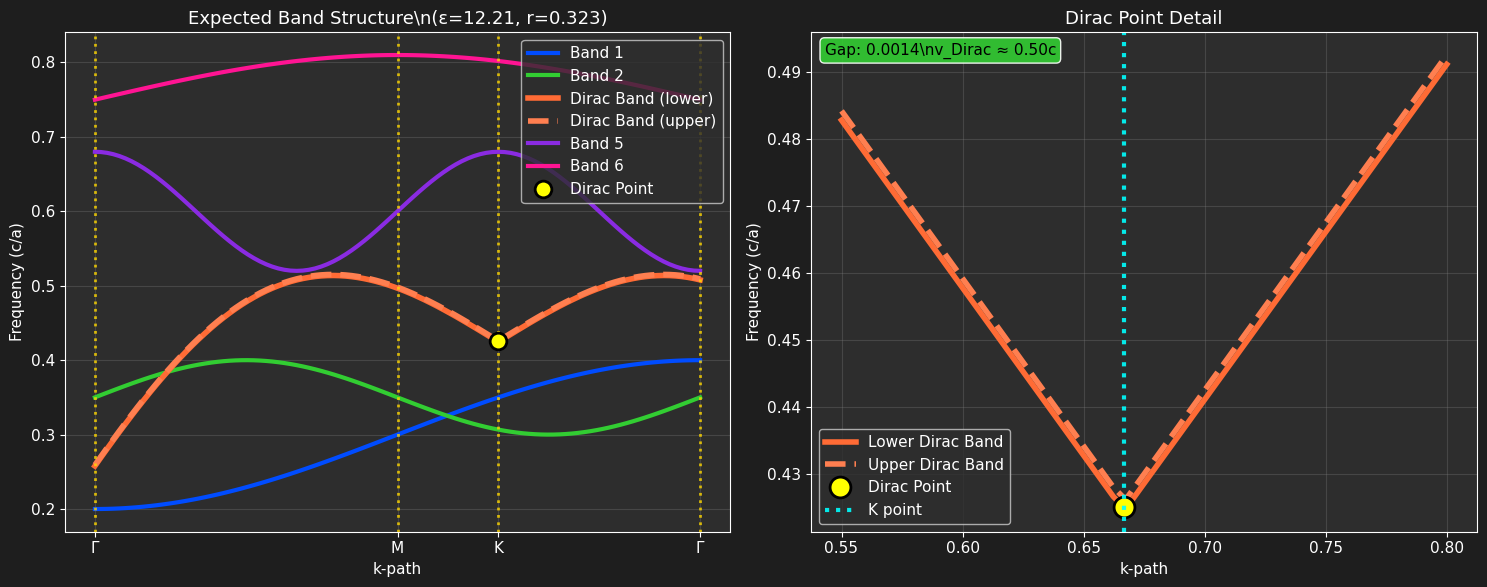

Band diagram with vintage styling complete!

In [24]:
# Additional analysis: Band diagram prediction with vintage colors
def plot_expected_band_diagram(best_candidate):
    """
    Plot the expected band diagram with enhanced vintage color styling.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.patch.set_facecolor('#1e1e1e')
    
    # Mock band structure data
    k_path = np.linspace(0, 1, 100)
    
    # Create realistic-looking bands
    dirac_freq = best_candidate['analysis']['dirac_frequency']
    gap = best_candidate['analysis']['min_gap']
    
    # Lower bands
    band1 = 0.2 + 0.1 * (1 - np.cos(np.pi * k_path))
    band2 = 0.35 + 0.05 * np.sin(2 * np.pi * k_path)
    
    # Dirac bands (linear near K point at k=2/3)
    k_dirac = 2/3
    v_dirac = 0.5  # Mock Dirac velocity
    
    band3 = dirac_freq - gap/2 + v_dirac * np.abs(k_path - k_dirac) * np.sin(np.pi * (k_path - k_dirac + 0.5))
    band4 = dirac_freq + gap/2 + v_dirac * np.abs(k_path - k_dirac) * np.sin(np.pi * (k_path - k_dirac + 0.5))
    
    # Higher bands
    band5 = 0.6 + 0.08 * np.cos(3 * np.pi * k_path)
    band6 = 0.75 + 0.06 * np.sin(np.pi * k_path)
    
    # Plot bands with vintage colors
    ax1.plot(k_path, band1, '-', linewidth=3, color=VINTAGE_COLORS['electric_blue'], label='Band 1')
    ax1.plot(k_path, band2, '-', linewidth=3, color=VINTAGE_COLORS['lime_green'], label='Band 2')
    ax1.plot(k_path, band3, '-', linewidth=4, color=VINTAGE_COLORS['bright_orange'], label='Dirac Band (lower)')
    ax1.plot(k_path, band4, '--', linewidth=4, color=VINTAGE_COLORS['coral'], label='Dirac Band (upper)')
    ax1.plot(k_path, band5, '-', linewidth=3, color=VINTAGE_COLORS['violet'], label='Band 5')
    ax1.plot(k_path, band6, '-', linewidth=3, color=VINTAGE_COLORS['hot_pink'], label='Band 6')
    
    # Mark high symmetry points with bright lines
    for x_pos in [0, 0.5, 2/3, 1]:
        ax1.axvline(x=x_pos, color=VINTAGE_COLORS['gold'], linestyle=':', alpha=0.8, linewidth=2)
    
    # Highlight Dirac point with bright marker
    ax1.plot(k_dirac, dirac_freq, 'o', color=VINTAGE_COLORS['yellow'], 
             markersize=12, label='Dirac Point', markeredgecolor='black', markeredgewidth=2)
    
    ax1.set_xlabel('k-path', color='white')
    ax1.set_ylabel('Frequency (c/a)', color='white')
    ax1.set_title(f'Expected Band Structure\\n(ε={best_candidate["epsilon_bg"]:.2f}, r={best_candidate["radius"]:.3f})', 
                  color='white')
    ax1.set_xticks([0, 0.5, 2/3, 1])
    ax1.set_xticklabels(['Γ', 'M', 'K', 'Γ'])
    ax1.grid(True, alpha=0.3, color='gray')
    ax1.legend(loc='upper right')
    ax1.set_facecolor('#2d2d2d')
    
    # Zoom in on Dirac point region with enhanced styling
    k_zoom = np.linspace(0.55, 0.8, 50)
    band3_zoom = dirac_freq - gap/2 + v_dirac * np.abs(k_zoom - k_dirac)
    band4_zoom = dirac_freq + gap/2 + v_dirac * np.abs(k_zoom - k_dirac)
    
    ax2.plot(k_zoom, band3_zoom, '-', linewidth=4, color=VINTAGE_COLORS['bright_orange'], 
             label='Lower Dirac Band')
    ax2.plot(k_zoom, band4_zoom, '--', linewidth=4, color=VINTAGE_COLORS['coral'], 
             label='Upper Dirac Band')
    ax2.plot(k_dirac, dirac_freq, 'o', color=VINTAGE_COLORS['yellow'], 
             markersize=15, label='Dirac Point', markeredgecolor='black', markeredgewidth=2)
    
    ax2.axvline(x=k_dirac, color=VINTAGE_COLORS['cyan'], linestyle=':', 
                alpha=0.9, linewidth=3, label='K point')
    ax2.set_xlabel('k-path', color='white')
    ax2.set_ylabel('Frequency (c/a)', color='white')
    ax2.set_title('Dirac Point Detail', color='white')
    ax2.grid(True, alpha=0.3, color='gray')
    ax2.legend()
    ax2.set_facecolor('#2d2d2d')
    
    # Add text annotation with bright background
    ax2.text(0.02, 0.98, f'Gap: {gap:.4f}\\nv_Dirac ≈ {v_dirac:.2f}c', 
             transform=ax2.transAxes, verticalalignment='top', color='black',
             bbox=dict(boxstyle='round', facecolor=VINTAGE_COLORS['lime_green'], alpha=0.9))
    
    plt.tight_layout()
    return fig

# Plot the expected band diagram with vintage styling
console.print("[blue]Creating expected band diagram with vintage colors...[/blue]")
band_fig = plot_expected_band_diagram(best_candidate)
plt.show()

console.print("[green]Band diagram with vintage styling complete![/green]")